# ATE estimations from real RCT data
*This notebook examines the use of Bayesian Networks for estimating Average Treatment Effects (ATE) in Randomized Controlled Trials (RCTs) within the Neyman-Rubin potential outcome framework from the STAR trial datset.*

In [36]:
import pyAgrum as gum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as gexpl

from scipy.stats import gaussian_kde

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Real Data

The data used in this notbook come from the Tennessee Student/Teacher Achievement Ratio (STAR) trial. This randomized controlled trial was designed to assess the effects of smaller class sizes in primary schools (T) on students' academic performance (Y). 

The covariates in this study include:

* `gender`
* `age`
* `g1freelunch` being the number of lunchs provided to the child per day
* `g1surban` the localisation of the school (inner city or rural)
* `ethnicity`

In [37]:
# Preprocessing

# Load data - read everything as a string and then cast
star_df = pd.read_csv("./STAR_data.csv", sep=",", dtype=str)
star_df = star_df.rename(columns={"race": "ethnicity"})

# Fill na
star_df = star_df.fillna({"g1freelunch": 0, "g1surban": 0})
drop_star_l = ["g1tlistss", "g1treadss", "g1tmathss", "g1classtype",
"birthyear", "birthmonth", "birthday", "gender",
"ethnicity", "g1freelunch", "g1surban"]
star_df = star_df.dropna(subset=drop_star_l, how='any')

# Cast value types before processing
star_df["gender"] = star_df["gender"].astype(int)
star_df["ethnicity"] = star_df["ethnicity"].astype(int)

star_df["g1freelunch"] = star_df["g1freelunch"].astype(int)
star_df["g1surban"] = star_df["g1surban"].astype(int)
star_df["g1classtype"] = star_df["g1classtype"].astype(int)

# Keep only class type 1 and 2 (in the initial trial,
# 3 class types where attributed and the third one was big classes
# but with a teaching assistant)
star_df = star_df[~(star_df["g1classtype"] == 3)].reset_index(drop=True)

# Compute the outcome
star_df["Y"] = (star_df["g1tlistss"].astype(int) +
                star_df["g1treadss"].astype(int) +
                star_df["g1tmathss"].astype(int)) / 3

# Compute the treatment
star_df["T"] = star_df["g1classtype"].apply(lambda x: 0 if x == 2 \
                                                        else 1)

# Transform date to obtain age (Notice: if na --> date is NaT)
star_df["date"] = pd.to_datetime(star_df["birthyear"] + "/"
+ star_df["birthmonth"] + "/"
+ star_df["birthday"], yearfirst=True, errors="coerce")
star_df["age"] = (np.datetime64("1985-01-01") - star_df["date"])
star_df["age"] = star_df["age"].dt.days / 365.25

# Keep only covariates we consider predictive of the outcome
star_covariates_l = ["gender", "ethnicity", "age",
                     "g1freelunch", "g1surban"]
star_df = star_df[["Y", "T"] + star_covariates_l]

# Map numerical to categorical
star_df["gender"] = star_df["gender"].apply(lambda x: "Girl" if x == 2 \
                                            else "Boy").astype("category")
star_df["ethnicity"] = star_df["ethnicity"].map( \
    {1:"White", 2:"Black", 3:"Asian",
     4:"Hispanic",5:"Nat_American", 6:"Other"}).astype("category")
star_df["g1surban"] = star_df["g1surban"].map( \
    {1:"Inner_city", 2:"Suburban",
     3:"Rural", 4:"Urban"}).astype("category")

star_df.head()

,Y,T,gender,ethnicity,age,g1freelunch,g1surban
0,514.000000,0,Boy,White,4.596851,2,Rural
1,512.666667,0,Girl,Black,5.694730,1,Inner_city
2,470.333333,1,Girl,Black,4.180698,1,Suburban
3,500.666667,1,Girl,White,5.963039,2,Urban
4,516.333333,0,Boy,Black,5.867214,1,Inner_city


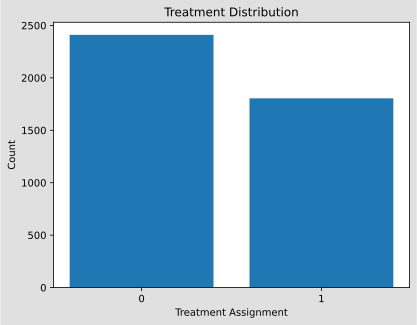

In [38]:
plt.bar([0,1], [(star_df["T"] == t).sum() for t in [0,1]])
plt.xticks(ticks=[0,1])
plt.xlabel("Treatment Assignment")
plt.ylabel("Count")
plt.title("Treatment Distribution")
plt.show()

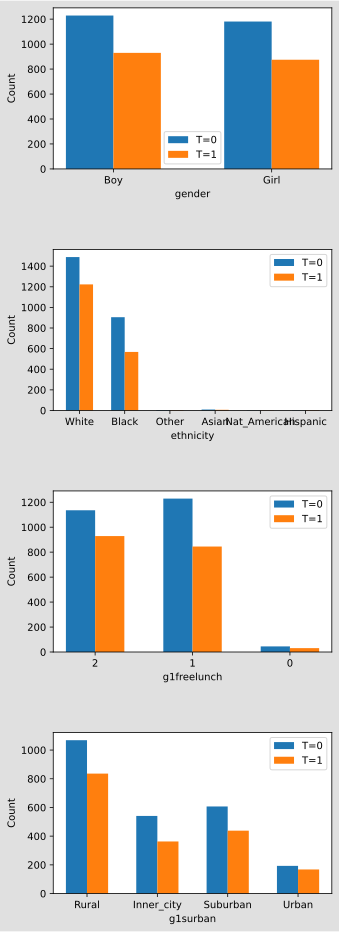

In [67]:
covar_list = ["gender", "ethnicity", "g1freelunch", "g1surban"]
width = 0.3

df0 = star_df[star_df["T"] == 0]
df1 = star_df[star_df["T"] == 1]

plt.subplots(figsize=(5,4*len(covar_list)))

for i in range(len(covar_list)):

    plt.subplot(len(covar_list), 1, i+1)

    X = star_df[covar_list[i]].unique()
    N = np.arange(len(X))
    height0 = [(df0[covar_list[i]] == X[j]).sum() for j in N]
    height1 = [(df1[covar_list[i]] == X[j]).sum() for j in N]

    plt.bar(N, height0, width, label="T=0")
    plt.bar(N+width, height1, width, label="T=1")

    plt.xlabel(covar_list[i])
    plt.ylabel("Count")

    plt.xticks(N + width / 2, X)

    plt.legend()


plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

The control and treatment groups appear to be similar, indicating that the ignorability assumption is likely satisfied.

In [14]:
# Declaration of function used in this section

def getStringIntervalMean(interval_string : str) -> float:
    """
    Returns the mean of a interval casted as string (e.g. [1.5, 2.9[).
    """

    separator = 0
    start = ""
    end = ""
    for c in interval_string:
        if str.isdecimal(c) or c in {"-", "."}:
            if separator == 1:
                start += c
            else:
                end += c
        else:
            separator += 1
    start = float(start)
    end = float(end)

    return (start + end)/2.0

def getY(bn : gum.BayesNet) -> tuple[pd.DataFrame]:
    """
    Returns the estimation of outcomes Y(0), Y(1) with Lazy Propagation
    from the inputed Baysian Network as a pandas Data Frame couple.
    """

    ie = gum.LazyPropagation(bn)

    ie.setEvidence({"T": 0})
    ie.makeInference()
    var_labels = list()
    var = ie.posterior("Y").variable(0)
    for i in range(var.domainSize()):
        var_labels.append(var.label(i))
    Y0 = pd.DataFrame({"T": 0, "interval": var_labels,
                       "probability": ie.posterior("Y").tolist()})
    Y0["interval_mean"] = Y0["interval"].apply(getStringIntervalMean)

    ie.setEvidence({"T": 1})
    ie.makeInference()
    var_labels = list()
    var = ie.posterior("Y").variable(0)
    for i in range(var.domainSize()):
        var_labels.append(var.label(i))
    Y1 = pd.DataFrame({"T": 1, "interval": var_labels,
                       "probability": ie.posterior("Y").tolist()})
    Y1["interval_mean"] = Y1["interval"].apply(getStringIntervalMean)

    return (Y0, Y1)

def getTau(Y : tuple[pd.DataFrame]) -> float:
    """
    Returns estimation of the ATE tau from pandas Data Frame couple
    (Y(0), Y(1)).
    """

    E0 = (Y[0]["interval_mean"] * Y[0]["probability"]).sum()
    E1 = (Y[1]["interval_mean"] * Y[1]["probability"]).sum()
    tau = E1 - E0

    return tau

def toHist(X : list[float], Y : list[float],
           n : int = 1000) -> list[float]:
    """
    Transforms X, Y data from plotting to a
    histogram plotting format
    """
    res = list()
    for i in range(len(X)):
        res += [X[i]]*int(n*Y[i])
    return res

### 1 - Structure Learning

In the absence of prior knowledge regarding the distributions of the variables and their relationships, structure learning aims to identify the network's underlying structure. To assist the learning process, we will impose a slice order on the variables.

In [15]:
disc = skbn.BNDiscretizer(defaultDiscretizationMethod='uniform')
disc.setDiscretizationParameters("age", 'uniform', 24)
disc.setDiscretizationParameters("Y", 'uniform', 30)

template = disc.discretizedBN(star_df)

learner = gum.BNLearner(star_df, template)
learner.useNMLCorrection()
learner.useSmoothingPrior(1e-6)
learner.setSliceOrder([["T", "ethnicity", "gender", "age"],
                       ["g1surban", "g1freelunch", ], ["Y"]])
star_slbn = learner.learnBN()

print(learner)

gnb.sideBySide(gexpl.getInformation(star_slbn, size="50"),
               gnb.getInference(star_slbn, size="50"))

Filename               : /tmp/tmpvd9qasfr.csv
Size                   : (4215,7)
Variables              : Y[30], T[2], gender[2], ethnicity[6], age[24], g1freelunch[3], g1surban[4]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {ethnicity:0, T:0, g1surban:1, age:0, gender:0, g1freelunch:1, Y:2}



This initial approach appears promising, as the inferred causal relationships are somewhat consistent with what might be expected from an non-expert perspective.

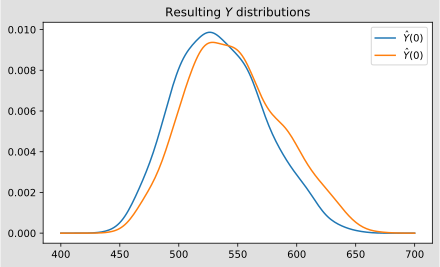

Estimated ATE : 11.51375626395145


In [16]:
Y_hat = getY(star_slbn)

x0, y0 = (Y_hat[0]["interval_mean"].to_numpy(),
          Y_hat[0]["probability"].to_numpy())
x1, y1 = (Y_hat[1]["interval_mean"].to_numpy(),
          Y_hat[1]["probability"].to_numpy())

density0 = gaussian_kde(toHist(x0, y0))
density1 = gaussian_kde(toHist(x1, y1))
xs = np.linspace(400,700,200)

plt.figure(figsize=(7, 4))

plt.plot(xs, density0(xs), color="tab:blue", label=r"$\hat{Y}(0)$")

plt.plot(xs, density1(xs), color="tab:orange", label=r"$\hat{Y}(0)$")


plt.legend()
plt.title("Resulting $Y$ distributions")
plt.show()

print(f"Estimated ATE : {getTau(Y_hat)}")

We observe a slight shift in the outcome distribution. However, because the outcome values are in the hundreds, this leads to a significant impact on the treatment effect, considering that the outcome is defined as the average of the students' three grades.

### 2 - Parameter Learning

Using different structures when conducting parameter learning can yield varying results. For the sake of illustration, we will examine how the estimation performs when arcs from the `age` and `gender` covariates are added to the outcome.

In [17]:
disc = skbn.BNDiscretizer(defaultDiscretizationMethod='uniform')
disc.setDiscretizationParameters("age", 'uniform', 24)
disc.setDiscretizationParameters("Y", 'uniform', 30)

template = disc.discretizedBN(star_df)

learner = gum.BNLearner(star_df, template)
learner.useNMLCorrection()
learner.useSmoothingPrior(1e-6)

star_plbn = gum.BayesNet(template)
star_plbn.addArc("T","Y")
star_plbn.addArc("ethnicity","g1surban")
star_plbn.addArc("ethnicity","g1freelunch")
star_plbn.addArc("g1surban","g1freelunch")
star_plbn.addArc("g1freelunch","Y")
star_plbn.addArc("gender","Y")
star_plbn.addArc("age","Y")

learner.fitParameters(star_plbn)

print(learner)

gnb.sideBySide(gexpl.getInformation(star_plbn, size="50"),
               gnb.getInference(star_plbn, size="50"))

Filename       : /tmp/tmpud45te2q.csv
Size           : (4215,7)
Variables      : Y[30], T[2], gender[2], ethnicity[6], age[24], g1freelunch[3], g1surban[4]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000001



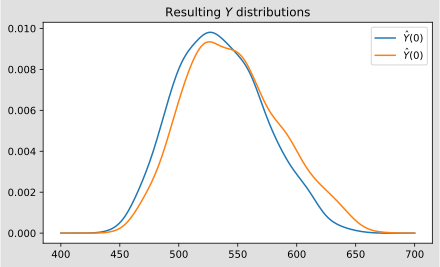

Estimated ATE : 10.344241933416356


In [18]:
Y_hat = getY(star_plbn)

x0, y0 = (Y_hat[0]["interval_mean"].to_numpy(),
          Y_hat[0]["probability"].to_numpy())
x1, y1 = (Y_hat[1]["interval_mean"].to_numpy(),
          Y_hat[1]["probability"].to_numpy())

density0 = gaussian_kde(toHist(x0, y0))
density1 = gaussian_kde(toHist(x1, y1))
xs = np.linspace(400,700,200)

plt.figure(figsize=(7, 4))

plt.plot(xs, density0(xs), color="tab:blue", label=r"$\hat{Y}(0)$")

plt.plot(xs, density1(xs), color="tab:orange", label=r"$\hat{Y}(0)$")


plt.legend()
plt.title("Resulting $Y$ distributions")
plt.show()

print(f"Estimated ATE : {getTau(Y_hat)}")

As anticipated, there are observable differences between the parameter learning method and the structure learning method. When compared to direct estimation methods, such as the Difference in Means (DM) estimator and the T-Learner using Ordinary Least Squares (OLS) regression, which yield average treatment effects of 12.81 and 10.77, respectively, our findings remain largely consistent. These results suggest that incorporating age and gender variables into the outcome model may deteriorate the final estimation accuracy.